In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Masque les warnings TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models

# 📂 Chemins des données
DATASET_PATH = "../data/chest_xray/"
IMG_SIZE = (64, 64)


100%|███████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 987.59it/s]


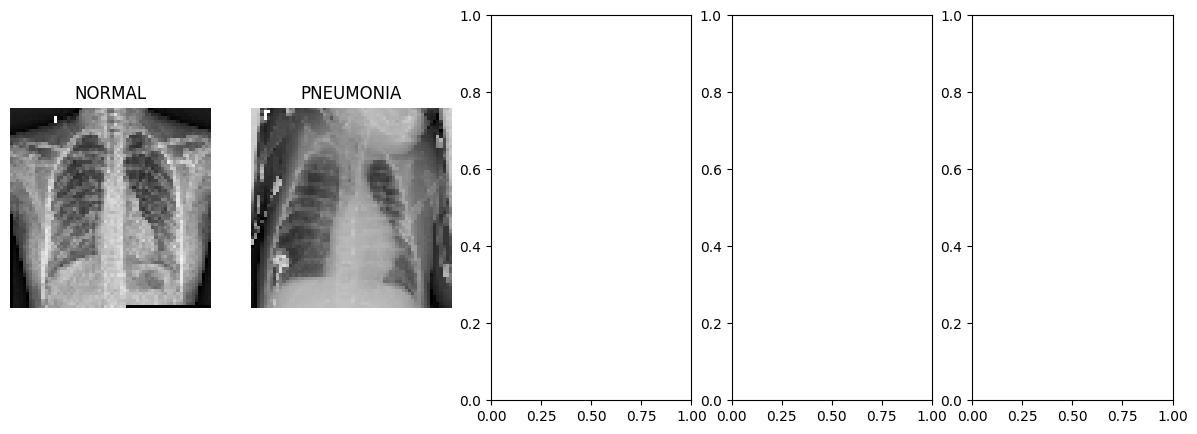

In [23]:
def load_images_and_labels(dataset_path, augment=False):
    X, Y = [], []
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(dataset_path, category)
        label = 0 if category == "NORMAL" else 1
        for img_name in tqdm(os.listdir(path)[:1000]):  # Limité pour éviter surcharge mémoire
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                img = np.expand_dims(img, axis=-1)  # Ajouter le canal pour augmentation
                X.append(img)
                Y.append(label)
    X = np.array(X) / 255.0  # Normalisation
    Y = np.array(Y)
    return X, Y

# Charger les images
X_train, Y_train = load_images_and_labels(os.path.join(DATASET_PATH, "train"))
X_test, Y_test = load_images_and_labels(os.path.join(DATASET_PATH, "test"))

# Affichage des images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
categories = ["NORMAL", "PNEUMONIA"]

for i, category in enumerate(categories):
    path = os.path.join(DATASET_PATH, "train", category)
    img_name = os.listdir(path)[0]
    img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(category)
    axes[i].axis("off")

plt.show()


In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# ✅ Charger les données
X_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_train.npy")
Y_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_train.npy")
X_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_test.npy")
Y_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_test.npy")

# ✅ Vérifier les dimensions après chargement
print("\n📊 Vérification des tailles des données après chargement :")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

# ✅ Correction du format des labels
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

# ✅ Vérification de la cohérence entre images et labels
if X_train.shape[0] != Y_train.shape[0] or X_test.shape[0] != Y_test.shape[0]:
    raise ValueError("❌ Erreur : Incohérence entre le nombre d'images et de labels.")

# ✅ Aplatir les images pour KNN (de (64,64) à (4096,))
X_train_knn = X_train.reshape(X_train.shape[0], -1)
X_test_knn = X_test.reshape(X_test.shape[0], -1)
print(f"X_train_knn shape après reshape: {X_train_knn.shape}")

# ✅ Normalisation des données
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_knn)
X_test_knn = scaler.transform(X_test_knn)

# ✅ Création d'un pipeline PCA + KNN
pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

# ✅ Tuning des hyperparamètres avec GridSearchCV
param_grid = {
    'pca__n_components': [50, 100, 150, 200, 250],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1)
grid_search.fit(X_train_knn, Y_train)
print("\n🔍 Meilleurs paramètres trouvés :", grid_search.best_params_)

# ✅ Entraîner le modèle KNN optimisé avec la réduction de dimension
best_pipeline = grid_search.best_estimator_
Y_pred_knn = best_pipeline.predict(X_test_knn)
accuracy = accuracy_score(Y_test, Y_pred_knn)

print(f"\n✅ Accuracy du modèle KNN : {accuracy:.4f}")
print("\n📊 Rapport de classification :\n", classification_report(Y_test, Y_pred_knn))



📊 Vérification des tailles des données après chargement :
X_train shape: (5216, 64, 64)
Y_train shape: (5216,)
X_test shape: (624, 64, 64)
Y_test shape: (624,)
X_train_knn shape après reshape: (5216, 4096)
Fitting 5 folds for each of 80 candidates, totalling 400 fits

🔍 Meilleurs paramètres trouvés : {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 50}

✅ Accuracy du modèle KNN : 0.7740

📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.75       624



/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🔍 Répartition des classes dans Y_train: {np.int64(0): np.int64(1341), np.int64(1): np.int64(3875)}
🔍 Répartition des classes dans Y_test: {np.int64(0): np.int64(234), np.int64(1): np.int64(390)}
⚖️ Poids calculés pour les classes : {np.int64(0): np.float64(1.9448173005219984), np.int64(1): np.float64(0.6730322580645162)}
Epoch 1/30


/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6460 - loss: 1.0453
Epoch 1: val_loss improved from inf to 0.98168, saving model to models/best_cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6465 - loss: 1.0443 - val_accuracy: 0.6250 - val_loss: 0.9817 - learning_rate: 2.0000e-05
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8278 - loss: 0.6912
Epoch 2: val_loss improved from 0.98168 to 0.96149, saving model to models/best_cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8279 - loss: 0.6911 - val_accuracy: 0.6250 - val_loss: 0.9615 - learning_rate: 2.0000e-05
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8525 - loss: 0.6589
Epoch 3: val_loss did not improve from 0.96149
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8525 - loss: 0.6588 - val_accuracy: 0.6250 - val_loss: 1.3032 - learning_rate: 2.0000e-05
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8629 - los

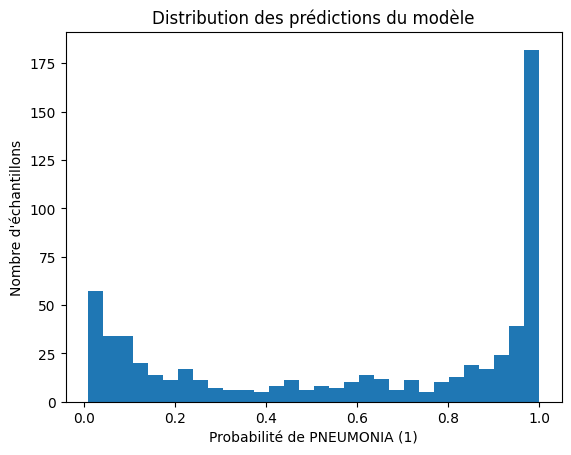

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


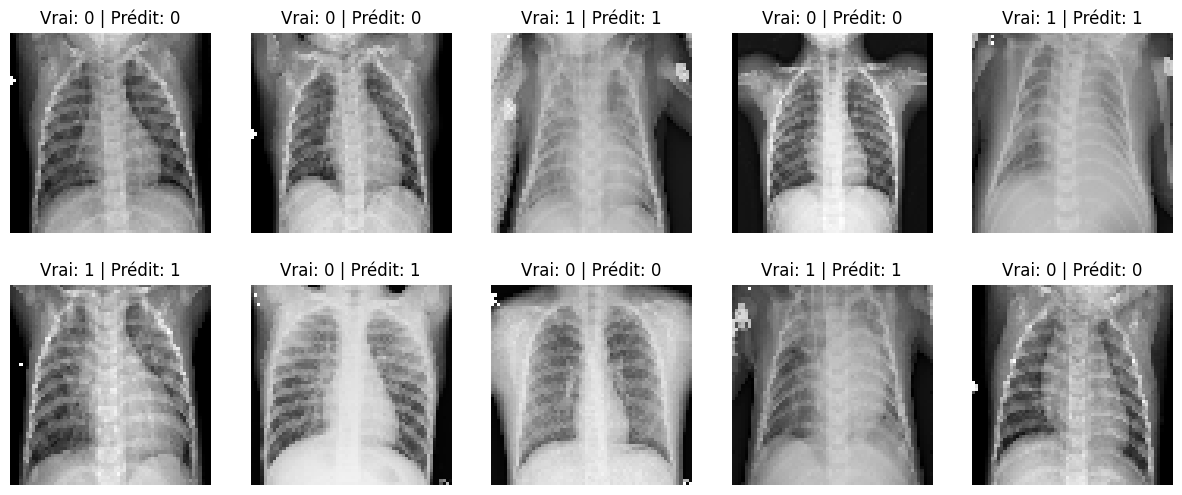

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ✅ 1️⃣ Charger et vérifier les données
X_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_train.npy")
Y_train = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_train.npy")
X_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_test.npy")
Y_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_test.npy")

# ✅ 2️⃣ Vérifier la répartition des classes
unique, counts = np.unique(Y_train, return_counts=True)
print(f"🔍 Répartition des classes dans Y_train: {dict(zip(unique, counts))}")
unique, counts = np.unique(Y_test, return_counts=True)
print(f"🔍 Répartition des classes dans Y_test: {dict(zip(unique, counts))}")

# ✅ 3️⃣ Calculer automatiquement les poids des classes pour corriger le déséquilibre
classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weights_dict = dict(zip(classes, class_weights))
print(f"⚖️ Poids calculés pour les classes : {class_weights_dict}")

# ✅ 4️⃣ Reshape et normalisation des images pour le CNN
X_train = X_train.reshape(-1, 64, 64, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 64, 64, 1).astype('float32') / 255.0

# ✅ 5️⃣ Augmenter les données pour éviter l’overfitting et améliorer la généralisation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# ✅ 6️⃣ Définition du modèle CNN amélioré avec BatchNormalization et régularisation L2
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Réduction de l'overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Sortie binaire
])

# ✅ 7️⃣ Compilation du modèle avec un learning rate bas pour un apprentissage stable
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ 8️⃣ Définition des callbacks pour optimiser l'entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("models/best_cnn_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
]

# ✅ 9️⃣ Entraînement avec augmentation des données et correction du déséquilibre des classes
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, Y_test),
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

# ✅ 🔟 Évaluation du modèle CNN
Y_pred_prob = model.predict(X_test)
Y_pred = (Y_pred_prob > 0.5).astype("int32")
accuracy = np.mean(Y_pred.flatten() == Y_test)

print(f"\n✅ Accuracy du modèle CNN : {accuracy:.4f}")
print("\n📊 Rapport de classification :\n", classification_report(Y_test, Y_pred))

# ✅ 🔥 Vérification de la distribution des probabilités prédites
plt.hist(Y_pred_prob, bins=30)
plt.title("Distribution des prédictions du modèle")
plt.xlabel("Probabilité de PNEUMONIA (1)")
plt.ylabel("Nombre d'échantillons")
plt.show()

# ✅ 🖼️ Tester les prédictions sur des images aléatoires
indices = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[indices]
Y_sample_true = Y_test[indices]

# Faire des prédictions sur un échantillon aléatoire
Y_sample_pred = (model.predict(X_sample) > 0.5).astype("int32")

# Afficher les images avec les prédictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i].reshape(64, 64), cmap="gray")
    ax.set_title(f"Vrai: {Y_sample_true[i]} | Prédit: {Y_sample_pred[i][0]}")
    ax.axis("off")
plt.show()

# ✅ 💾 Sauvegarde du modèle optimisé
model.save("models/cnn_pneumonia_fixed.keras")


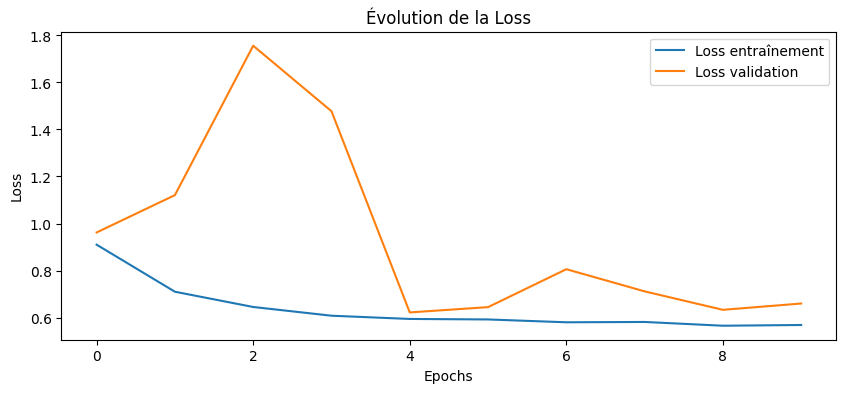

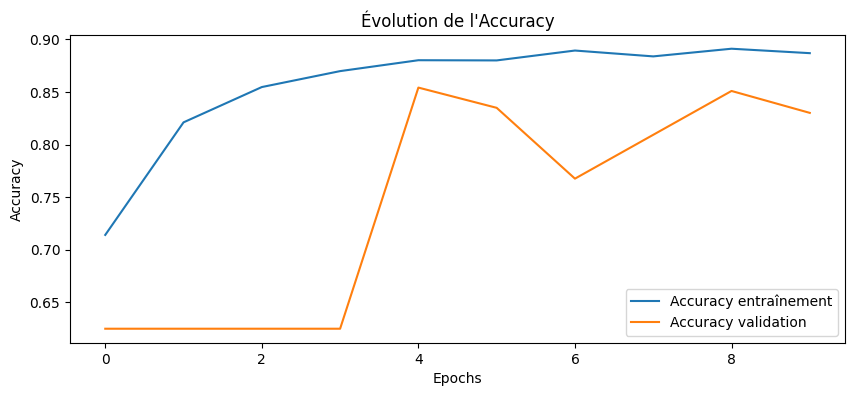

In [2]:
import matplotlib.pyplot as plt

# Récupérer l'historique d'entraînement
history_dict = history.history

# 📊 Courbe de la perte (loss)
plt.figure(figsize=(10, 4))
plt.plot(history_dict['loss'], label='Loss entraînement')
plt.plot(history_dict['val_loss'], label='Loss validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Évolution de la Loss")
plt.show()

# 📊 Courbe de l'accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_dict['accuracy'], label='Accuracy entraînement')
plt.plot(history_dict['val_accuracy'], label='Accuracy validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Évolution de l'Accuracy")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
🔍 Prédiction : NORMAL (Probabilité: 0.0000)


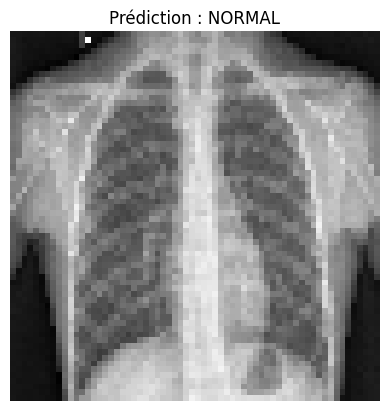

In [3]:
import cv2
import os

def predict_image(image_path):
    IMG_SIZE = (64, 64)
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Erreur : Impossible de charger l'image.")
        return
    
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalisation
    img = img.reshape(1, 64, 64, 1)  # Format pour le CNN

    prediction = model.predict(img)[0][0]
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"

    print(f"🔍 Prédiction : {label} (Probabilité: {prediction:.4f})")

    plt.imshow(img.reshape(64, 64), cmap='gray')
    plt.title(f"Prédiction : {label}")
    plt.axis("off")
    plt.show()

# 📌 Tester avec une image spécifique (Modifie le chemin)
test_image_path = "../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # Change l’image ici
if os.path.exists(test_image_path):
    predict_image(test_image_path)
else:
    print("❌ L'image test spécifiée n'existe pas. Vérifie le chemin.")


<Figure size 600x600 with 0 Axes>

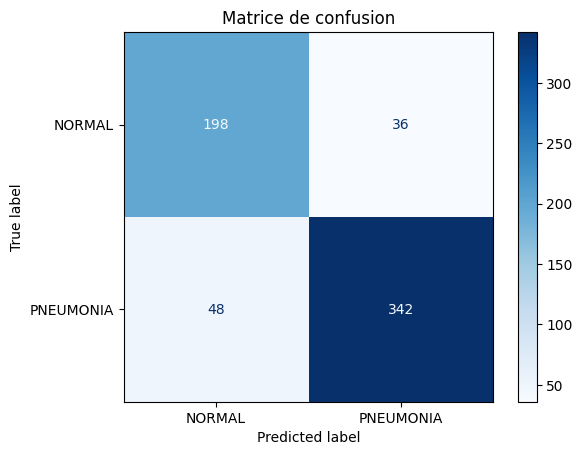

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 📌 Générer la matrice de confusion
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])

# 📊 Afficher la matrice de confusion
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matrice de confusion")
plt.show()


Nouvelle forme de X_test : (624, 64, 64, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Statistiques des probabilités prédites : min = 0.0091, max = 0.9996, mean = 0.6005
AUC : 0.94


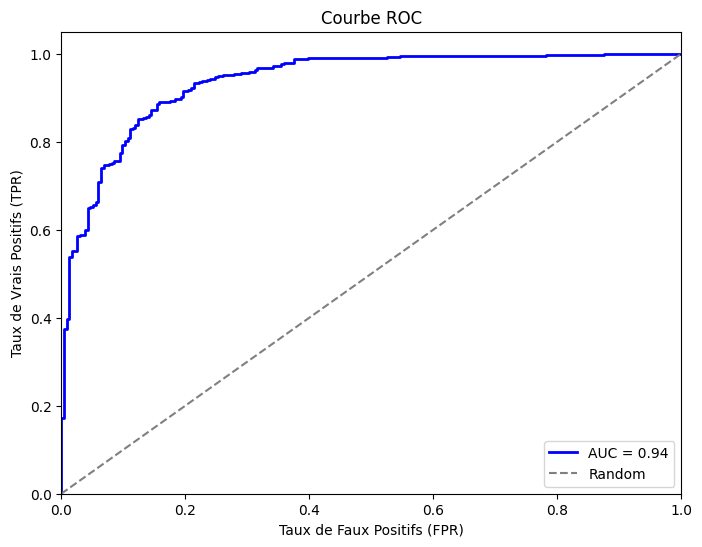

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# ✅ Charger les données de test
X_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/X_test.npy")
Y_test = np.load("/Users/antoinegourgue/Desktop/Projects/medical-ai-detection/data/Y_test.npy")

# ✅ Correction du format des images : ajouter la dimension du canal si nécessaire
if len(X_test.shape) == 3:  # Si la forme est (num_images, 64, 64)
    X_test = X_test.reshape(X_test.shape[0], 64, 64, 1)
    print("Nouvelle forme de X_test :", X_test.shape)

# ✅ Normaliser les images (même prétraitement que lors de l'entraînement)
X_test = X_test.astype('float32') / 255.0

# ✅ Charger le modèle entraîné
model = tf.keras.models.load_model("models/cnn_pneumonia_fixed.keras")

# ✅ Calcul des probabilités prédites
Y_pred_prob = model.predict(X_test).ravel()
print("Statistiques des probabilités prédites : min = {:.4f}, max = {:.4f}, mean = {:.4f}".format(
    Y_pred_prob.min(), Y_pred_prob.max(), Y_pred_prob.mean()))

# ✅ Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC : {:.2f}".format(roc_auc))

# ✅ Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()
